In [27]:
#load in parent stuff

import nb_load_stuff
from tectModelClass import *

In [28]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

In [29]:
from unsupported_dan.UWsubduction.base_params import *
from unsupported_dan.UWsubduction.subduction_utils import *
from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection
from unsupported_dan.interfaces.smoothing2D import *

In [30]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator




## Changes to base params

In [31]:
ndp.depth *= 0.8 #800 km
ndp.faultThickness *= 1.5 #15 km
ndp.interfaceViscCutoffDepth *= 1.5 #150 km


## Build mesh, Stokes Variables

In [32]:
#(ndp.rightLim - ndp.leftLim)/ndp.depth
#md.res = 64

In [33]:
yres = int(md.res)
xres = int(md.res*12) 

mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (ndp.leftLim, 1. - ndp.depth), 
                                 maxCoord    = (ndp.rightLim, 1.)) 

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )


velocityField.data[:] = 0.
pressureField.data[:] = 0.

## Build plate model

In [34]:
#Set up some velocityies
cm2ms = (1/100.)*(1./(3600*24*365)) 

v1= 2.*cm2ms #m/s
v1 /= sf.velocity

v2= -2.*cm2ms #
v2 /= sf.velocity



ma2s = 1e6*(3600*24*365)
endTime = 20*ma2s/sf.time
dt = 0.1*ma2s/sf.time
testTime = 5*ma2s/sf.time


In [35]:
#20 Ma moddel, timestep of 200 Ka 
tg = TectModel(mesh, 0, endTime, dt)

tg.add_plate(1)
tg.add_plate(2)
tg.add_plate(3)

In [36]:
tg.add_left_boundary(1)
tg.add_subzone(1, 2, ndp.subZoneLoc, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)
tg.add_subzone(3, 2., 0.4, subInitAge=ndp.slabMaxAge, upperInitAge=ndp.opMaxAge)

tg.add_right_boundary(3, 0.)

## Build plate age

In [37]:
pIdFn = tg.plate_id_fn()
pAgeDict = tg.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tg.mesh, fnAge_map ))
#fig.show()

In [38]:
coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]
plateTempProxFn = ndp.potentialTemp*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))

In [39]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tg.mesh, plateTempProxFn))
#fig.show()

## Make swarm and Slabs

In [40]:
def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < ndp.radiusOfCurv:
        return max(-S/np.sqrt((ndp.radiusOfCurv**2 - S**2)), -1e3)
    else:
        return -1e5

In [41]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(20))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )

#
proxyTempVariable.data[:] = 1.0
proximityVariable.data[:] = 0.0
signedDistanceVariable.data[:] = 0.0


In [42]:
#All of these wil be needed by the slab / fault setup functions
#We have two main options, bind them to the TectModel class. 
#or provide them to the functions
#collection them in a dictionary may be a useful way too proviede them to the fucntiosn 
#wthout blowing out the function arguments

tmUwMap = tm_uw_map([], velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)




In [43]:
#define fault particle spacing, here ~2 particles per element
ds = (tg.maxX - tg.minX)/(2.*tg.mesh.elementRes[0])

fCollection = line_collection([])




for e in tg.undirected.edges():
    if tg.is_subduction_boundary(e):
        build_slab_distance(tg, e, circGradientFn, ndp.maxDepth, tmUwMap)        
        fb = build_fault(tg, e, circGradientFn,ndp.faultThickness , ndp.maxDepth, ds, ndp.faultThickness, tmUwMap)
        fCollection.append(fb)

#
build_slab_temp(tmUwMap, ndp.potentialTemp, ndp.slabMaxAge)
fnJointTemp = fn.misc.min(proxyTempVariable,plateTempProxFn)

#And now reevaluate this guy on the swarm
proxyTempVariable.data[:] = fnJointTemp.evaluate(swarm)


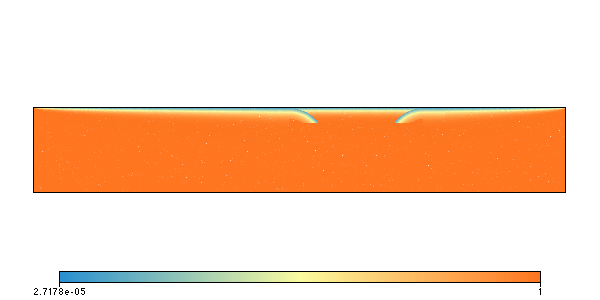

In [46]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Points(swarm, proxyTempVariable))
    

#fig.show()
#fig.save_database('test.gldb')

##  Fault rebuild

In [47]:
# Setup a swarm to define the replacment positions

fThick= fCollection[0].thickness

faultloc = 1. - ndp.faultThickness*md.faultLocFac

allxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0], ds )[:-1]
allys = (mesh.maxCoord[1] - fThick)*np.ones(allxs.shape)

faultMasterSwarm = uw.swarm.Swarm( mesh=mesh )
dummy =  faultMasterSwarm.add_particles_with_coordinates(np.column_stack((allxs, allys)))
del allxs
del allys

In [48]:
ridgedist = 400e3/sf.lengthScale
subdist = 150e3/sf.lengthScale


ridgeMaskFn = tg.ridge_mask_fn(ridgedist)
subMaskFn = tg.subduction_mask_fn(subdist)
boundMaskFn = tg.combine_mask_fn(ridgeMaskFn , subMaskFn )


In [49]:
dummy = remove_faults_from_boundaries(fCollection, ridgeMaskFn)
dummy = remove_fault_drift(fCollection, faultloc)
dummy = pop_or_perish(tg, fCollection, faultMasterSwarm, boundMaskFn, ds)

In [50]:
#A = fCollection[0].neighbourMatrix(k =4, jitter=1e-8)
#out = shadowMask(fCollection[0])
#out

In [51]:
#test = fCollection[1]
#np.unique(test.swarm.particleCoordinates.data[:,0]).shape, (test.swarm.particleCoordinates.data[:,0]).shape

## Proximity



In [52]:
proximityVariable.data[:] = 0

In [53]:
for f in fCollection:
    f.rebuild()
    f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0)

## Boundary conditions

In [54]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]


velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )


## Bouyancy

In [55]:
# Now create a buoyancy force vector using the density and the vertical unit vector. 
thermalDensityFn = ndp.rayleigh*(1. - proxyTempVariable)

gravity = ( 0.0, -1.0 )

buoyancyMapFn = thermalDensityFn*gravity

## Rheology

In [25]:
symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )

#Set up any functions required by the rheology
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [26]:
temperatureFn = proxyTempVariable
adiabaticCorrectFn = depthFn*ndp.tempGradMantle
dynamicPressureProxyDepthFn = pressureField/sf.pressureDepthGrad
druckerDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlpha*(dynamicPressureProxyDepthFn))

#Diffusion Creep
diffusionUM = (1./ndp.diffusionPreExp)*\
            fn.math.exp( ((ndp.diffusionEnergy + (depthFn*ndp.diffusionVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

diffusionUM =     safe_visc(diffusionUM)
    
diffusionLM = ndp.lowerMantleViscFac*(1./ndp.lowerMantlePreExp)*\
            fn.math.exp( ((ndp.lowerMantleEnergy + (depthFn*ndp.lowerMantleVolume))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

diffusionLM =     safe_visc(diffusionLM)

    
#combine upper and lower mantle   
mantleCreep = fn.branching.conditional( ((depthFn < ndp.lowerMantleDepth, diffusionUM ), 
                                           (True,                      diffusionLM )  ))

#Define the mantle Plasticity
ys =  ndp.cohesionMantle + (druckerDepthFn*ndp.frictionMantle)
ysf = fn.misc.min(ys, ndp.yieldStressMax)
yielding = ysf/(2.*(strainRate_2ndInvariant) + 1e-15) 


mantleRheologyFn = safe_visc(fn.misc.min(mantleCreep, yielding), viscmin=ndp.viscosityMin, viscmax=ndp.viscosityMax)

#Subduction interface viscosity
interfaceViscosityFn = fn.misc.constant(0.5)

In [28]:
#viscconds = ((proximityVariable == 0, mantleRheologyFn),
#             (True, interfaceViscosityFn ))

#viscosityMapFn = fn.branching.conditional(viscconds)
#viscosityMapFn = mantleRheologyFn


viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = {0:mantleRheologyFn,
                                        1:interfaceViscosityFn,
                                       3:interfaceViscosityFn} )

## Stokes

In [29]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)

NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressureField, type=0)
Nodes2Cell = uw.utils.MeshVariable_Projection(pressureField, NodePressure, type=0)

def smooth_pressure(mesh):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.

    Cell2Nodes.solve()
    Nodes2Cell.solve()

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh)

In [30]:
stokes = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velBC,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn )


In [31]:
solver = uw.systems.Solver(stokes)

solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4

In [32]:
solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol, callback_post_solve = pressure_calibrate)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 5.5847e-01
Pressure solve time: 5.4921e-02
Velocity solve time: 5.7282e-01 (backsolve)
Total solve time   : 1.2944e+00
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



## Swarm Advector

In [33]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )


## Update functions

In [34]:
# Here we'll handle everything that should be advected - i.e. every timestep
def advect_update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect swarm
    advector.integrate(dt)
    
    #Advect faults
    for f in fCollection:
        f.advection(dt)
    
    
    return time+dt, step+1

In [46]:
def update_faults():
    
    ##the mask fns are static at this stage
    #ridgeMaskFn = tg.ridge_mask_fn(ridgedist)
    #subMaskFn = tg.subduction_mask_fn(subdist)
    #boundMaskFn = tg.combine_mask_fn(ridgeMaskFn , subMaskFn )
    
    dummy = remove_faults_from_boundaries(fCollection, ridgeMaskFn)
    dummy = remove_fault_drift(fCollection, faultloc, tolFac =ds*2)
    dummy = pop_or_perish(tg, fCollection, faultMasterSwarm, boundMaskFn, ds*3)
    
    for f in fCollection:
        
        #Here we're grabbing a 'black box' routine , 
        #which is supposed to maintain particle density and smooth
        #quite experimental!!!
        repair_markerLines(f, ds)
    

In [47]:
def update_swarm():
    
    for f in fCollection:
        f.rebuild()
        f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0)
        
    #A simple depth cutoff for proximity
    depthMask = swarm.particleCoordinates.data[:,1] < (1. - ndp.interfaceViscCutoffDepth)
    proximityVariable.data[depthMask] = 0
    

In [48]:
#update_faults()
#update_swarm()

## Viz

In [49]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

In [50]:
store1 = glucifer.Store('output/subduction1')
store2 = glucifer.Store('output/subduction2')

figProx = glucifer.Figure(store1, figsize=(960,300) )
figProx.append( glucifer.objects.Points(swarm , proximityVariable))
for f in fCollection:
    figProx.append( glucifer.objects.Points(f.swarm, pointSize=5))
#figProx.show()

#Plot of particles stress invariant
figVisc = glucifer.Figure( store2, figsize=(960,300) )
figVisc.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2, logScale=True) )

In [51]:
#figProx.show()

In [52]:
#1e-2*2900.

## Main Loop

In [ ]:
time = 0.  # Initial time
step = 0 
maxSteps = 20      # Maximum timesteps (201 is recommended)
steps_output = 5   # output every 10 timesteps
faults_update = 2

In [ ]:
#while time < tg.times[-1]:
while step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    
    #advect swarm and faults
    time,step =  advect_update()
    
    #running fault healing/addition, map back to swarm
    if step % faults_update == 0:
        update_faults()      
#        update_swarm()
    
    
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        store1.step = step
        store2.step = step
        figProx.save(    outputPath + "proximity"    + str(step).zfill(4))
        figVisc.save(    outputPath + "visc"    + str(step).zfill(4))
    
    if uw.rank()==0:
        print 'step = {0:6d}; time = {1:.3e}'.format(step,time)


step =      1; time = 5.084e-06
step =      2; time = 9.962e-06
step =      3; time = 1.468e-05
step =      4; time = 1.920e-05
